In [5]:
using Images, TestImages, PyPlot, BenchmarkTools

In [6]:
using GPUArrays
using CLArrays

In [7]:
devices = CLArrays.devices()

2-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(AMD Radeon Pro 580 Compute Engine on Apple @0x0000000001021c00)       
 OpenCL.Device(Intel(R) Core(TM) i7-7700K CPU @ 4.20GHz on Apple @0x00000000ffffffff)

In [8]:
img = testimage("lena_gray");
img1 = Gray.(img);

### CPU convolution

In [9]:
K = [[1,1,1]  [0,0,0]  [-1,-1,-1]]
X = Float32.(img1);

In [43]:
function convolution_2d(X,K)
    im_width, im_height = size(X)    
    array_type = eltype(X)
    f = size(K, 1)
    output = zeros(eltype(X), im_width-f, im_height-f)
    @inbounds  for w in 1:im_width-f
        for h in 1:im_height-f
            aux = 0.
            l = 1
            for col in h:h+f-1
                for row in w:w+f-1
                    aux += X[row,col]*K[l]
                    l +=1
                end
            end
            output[w,h] = aux
        end
    end
    return output
end

convolution_2d (generic function with 1 method)

In [70]:
@time convolution_2d(X,K);

  0.000742 seconds (6 allocations: 250.297 KiB)


In [68]:
@benchmark convolution_2d(X,K)

BenchmarkTools.Trial: 
  memory estimate:  250.14 KiB
  allocs estimate:  2
  --------------
  minimum time:     557.911 μs (0.00% GC)
  median time:      643.514 μs (0.00% GC)
  mean time:        663.837 μs (3.43% GC)
  maximum time:     2.939 ms (71.28% GC)
  --------------
  samples:          7498
  evals/sample:     1

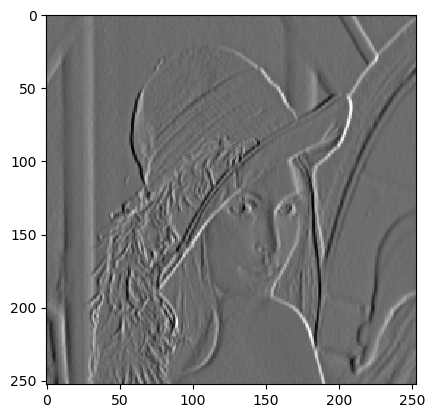

PyObject <matplotlib.image.AxesImage object at 0x10984da10>

In [45]:
Xconv = convolution_2d(X,K)
PyPlot.imshow(Xconv, cmap="gray")

### GPU convolution

In [46]:
devices[1]

OpenCL.Device(AMD Radeon Pro 580 Compute Engine on Apple @0x0000000001021c00)

In [47]:
CLArrays.init(devices[1])

OpenCL context with:
CL version: OpenCL 1.2 
Device: CL AMD Radeon Pro 580 Compute Engine
            threads: 256
             blocks: (256, 256, 256)
      global_memory: 8589.934592 mb
 free_global_memory: NaN mb
       local_memory: 0.032768 mb


In [59]:
X_gpu = CLArray(X);
X_conv = CLArray(zeros(X));
K_cl = CLArray(Float32.(K))

GPU: 3×3 Array{Float32,2}:
 1.0  0.0  -1.0
 1.0  0.0  -1.0
 1.0  0.0  -1.0

In [65]:
@time convolution!(X_gpu, X_conv, K_cl);

  0.000390 seconds (148 allocations: 6.016 KiB)


In [67]:
@benchmark convolution!(X_gpu, X_conv, K_cl)

BenchmarkTools.Trial: 
  memory estimate:  5.95 KiB
  allocs estimate:  148
  --------------
  minimum time:     93.105 μs (0.00% GC)
  median time:      119.797 μs (0.00% GC)
  mean time:        137.022 μs (0.71% GC)
  maximum time:     6.444 ms (75.37% GC)
  --------------
  samples:          10000
  evals/sample:     1

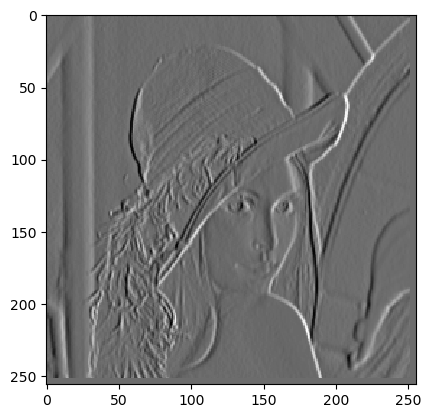

PyObject <matplotlib.image.AxesImage object at 0x13cdbc850>

In [71]:
PyPlot.imshow(Array(X_conv), cmap="gray")

### Little detail: GPUArrays conv seems to have padding by default

In [57]:
size(Xconv)

(253, 253)

In [58]:
size(X_conv)

(256, 256)

### Make a GPUcall

```
gpu_call(kernel::Function, A::GPUArray, args::Tuple, configuration = length(A))
```

```
# can only launch when using less threads then max_work_group_size/max threads
if threads <= threads(device) 
     gpu_call(func, (arg1, arg2, ...), (blocks, threads))
end
```



### Matrix multiplication benchmark

In matrix multiplications the speed difference is huge!

In [26]:
X_gpu = CLArray(rand(Float32,2048,2048));

In [28]:
r_gpu = CLArray(similar(X_gpu))
@time A_mul_B!(r_gpu, X_gpu, X_gpu);

  0.000034 seconds (100 allocations: 2.453 KiB)


In [29]:
X_cpu = Array(X_gpu);

In [31]:
r_cpu = similar(X_cpu)
@time A_mul_B!(r_cpu, X_cpu, X_cpu);

  0.156865 seconds (4 allocations: 160 bytes)


In [33]:
isapprox(r_cpu, Array(r_gpu))

true